In [1]:
import pickle

random = False
mv = False
ivr = True

exp_folder_name='experimental_design'
bay_folder_name='bayesian_optimization'

if random:
    bay_tl_file='520_random_init_50_bay_opt_timeLoss'
    bay_tl_res='results_random_init_timeLoss'
    bay_co2_file='520_random_init_50_bay_opt_emissions'
    bay_co2_res='results_random_init_emissions'

    output_dir = "random"
    if not os.path.isdir(output_dir):
        os.makedirs(output_dir)

elif mv:
    bay_tl_file='520_model_variance_50_bay_timeLoss'
    bay_tl_res='results_model_variance_timeLoss'
    bay_co2_file='520_model_variance_50_bay_emissions'
    bay_co2_res='results_model_variance_emissions'

    output_dir = "model_variance"
    if not os.path.isdir(output_dir):
        os.makedirs(output_dir)

elif ivr:
    bay_tl_file='520_integrated_variance_50_bay_timeLoss'
    bay_tl_res='results_integrated_variance_timeLoss'
    bay_co2_file='400_BO_loops_500_integrated_variance_CO2_ARD'
    bay_co2_res='results_400_BO_loops_500_integrated_variance_CO2_ARD'

    output_dir = "integrated_variance_reduction"
    if not os.path.isdir(output_dir):
        os.makedirs(output_dir)

bay_tl_model = pickle.load(open('../' + bay_folder_name + '/models/' + bay_tl_file + '.pkl', "rb"))
bay_co2_model = pickle.load(open('../' + bay_folder_name + '/models/' + bay_co2_file + '.pkl', "rb"))

In [2]:
from experimental_design.config import get_ofat_parameter_spaces_from_results, get_ofat_parameter_spaces
import pandas as pd

In [3]:
time_loss_results = pickle.load(open('../bayesian_optimization/bayesian_opt_results/' + bay_tl_res + '.pkl', 'rb'))
tl_op_point_df = pd.DataFrame(time_loss_results.minimum_location.reshape(1,-1), index=[0])
tl_op_point_df

,0,1,2,3,4
0,10.0,8.0,70.0,2.0,1.862688


In [4]:
emissions_results = pickle.load(open('../bayesian_optimization/bayesian_opt_results/' + bay_co2_res + '.pkl', 'rb'))
co2_op_point_df = pd.DataFrame(emissions_results.minimum_location.reshape(1,-1), index=[1])
co2_op_point_df

,0,1,2,3,4
1,20.0,8.0,61.368174,1.0,2.692604


In [5]:
joint_df = pd.concat([tl_op_point_df, co2_op_point_df])
joint_df

,0,1,2,3,4
0,10.0,8.0,70.000000,2.0,1.862688
1,20.0,8.0,61.368174,1.0,2.692604


In [6]:
mean_df = pd.DataFrame(joint_df.mean(axis=0)).transpose()
mean_df

,0,1,2,3,4
0,15.0,8.0,65.684087,1.5,2.277646


In [7]:
tl_parameter_spaces = get_ofat_parameter_spaces_from_results(mean_df)
co2_parameter_spaces = get_ofat_parameter_spaces_from_results(mean_df)

In [8]:
import numpy as np
def run_emu(model, test_X, idx):
    pred_Y, pred_Y_variance = model.predict(test_X)
    X = test_X[:, idx]
    Y = pred_Y[:, 0]
    V = pred_Y_variance[:, 0]
    sort_pos = X.argsort()
    X = X[sort_pos]
    Y = Y[sort_pos]
    std_dev = np.sqrt(V[sort_pos])
    return X, Y, std_dev

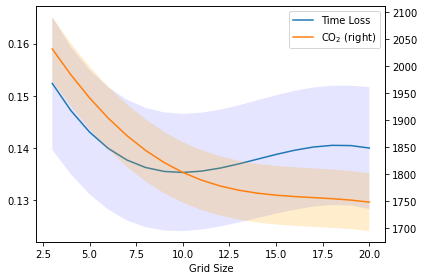

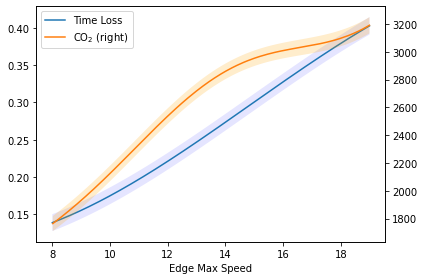

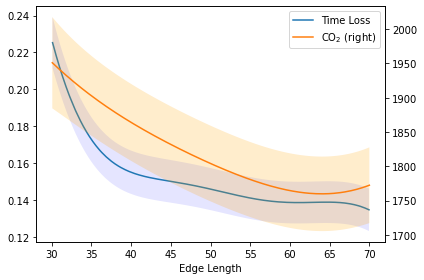

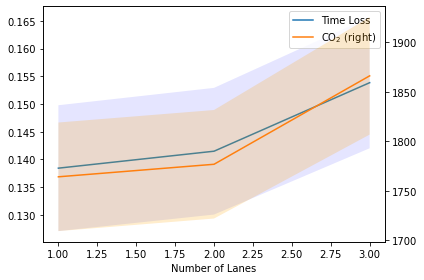

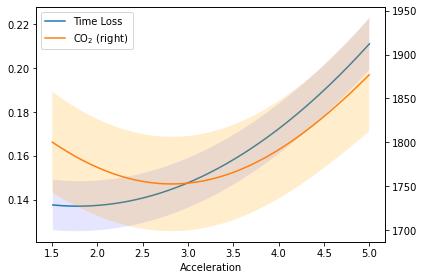

In [9]:
from emukit.core.initial_designs import RandomDesign
import pandas as pd
import matplotlib.pyplot as plt


num_data_points = 500
for idx, (tl_space_dict, co2_space_dict) in enumerate(list(zip(tl_parameter_spaces, co2_parameter_spaces))):
    fig, ax = plt.subplots()
    tl_parameter_name = tl_space_dict['name']
    tl_parameter_space = tl_space_dict['space']
    tl_design = RandomDesign(tl_parameter_space)  # initialize with random points
    tl_test_X = tl_design.get_samples(num_data_points)

    co2_parameter_name = co2_space_dict['name']
    co2_parameter_space = co2_space_dict['space']
    co2_design = RandomDesign(co2_parameter_space)  # initialize with random points
    co2_test_X = co2_design.get_samples(num_data_points)

    data = {}
    tl_X, bay_tl_Y, bay_tl_std = run_emu(bay_tl_model, tl_test_X, idx)

    data['tl_X'] = tl_X
    data['bay_tl_Y'] = bay_tl_Y
    data['bay_tl_std'] = bay_tl_std
    data['Time Loss'] = data['bay_tl_Y'] 
    _ax1 = pd.DataFrame(data).plot.line(x='tl_X', y=['Time Loss'], ax=ax)
    

    co2_X, bay_co2_Y, bay_co2_std = run_emu(bay_co2_model, co2_test_X, idx)
    data['co2_X'] = co2_X
    data['bay_co2_Y'] = bay_co2_Y
    data['bay_co2_std'] = bay_co2_std
    data['CO$_2$'] = data['bay_co2_Y']
    y_secondary = True
    _ax2 = pd.DataFrame(data).plot.line(secondary_y=y_secondary, x='co2_X', y=['CO$_2$'], ax=ax)

    _ax1.fill_between(tl_X, bay_tl_Y - bay_tl_std, bay_tl_Y + bay_tl_std, facecolor='blue', alpha=0.1, interpolate=True)
    _ax2.fill_between(co2_X, bay_co2_Y - bay_co2_std, bay_co2_Y + bay_co2_std, facecolor='orange', alpha=0.2, interpolate=True)
    ax.set_xlabel(co2_parameter_name)

    plt.subplots_adjust(hspace=0.3)
    fig.tight_layout()
    if not os.path.isdir(output_dir + '/ofat/'):
        os.makedirs(output_dir + '/ofat/')
    fig.savefig(output_dir + '/ofat/'+ co2_parameter_name.lower().replace(" ", "_") +'.pdf', format='pdf')